In [1]:
import os
os.chdir("../..")

In [2]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
# from src.utils.echo_utils import get2dPucks ### We are using a debugging version!!
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet
# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [3]:
%matplotlib widget
from src.strain import *

# for get2dpucks
from skimage.transform import (resize, 
                               rescale)
from skimage.segmentation import find_boundaries

In [4]:
batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

In [5]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

100%|██████████| 16/16 [00:01<00:00, 14.03it/s]


In [6]:
model_save_path = "save_models/Original_Pretrained_R2plus1DMotionSegNet.pth"

model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model.eval();

R2+1D MotionNet has 31575731 parameters.


In [7]:
test_pat_index = 55

video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

In [8]:
# let's try to use 9 pucks, if we divide into N=3 sections, we define each section to be 3 pucks
def get2dPucks(abin, apix, npucks=9, vis=False, debug=False):
    '''
    get2dPucks(abin, apix): Return the linear extent of the binary structure,
    as well as a sequence of radii about that extent.
    '''
    
    all_puck_endpoints = []
    
    
    # Empty bin?
    if ~np.any(abin):
        return 1.0, np.zeros((npucks,))
    
    x,y = np.where(abin>0)
    X = np.stack([x,y]) # Coords of all non-zero pixels., 2 x N
    if X.shape[1] < 1: # no pixels, doesn't seem to be a problem usually. 
        return (0.0, np.zeros((npucks,)))
    # Scale dimensions
    X = np.multiply(X, np.array(apix)[:, None]) # Need a broadcastable shape, here 2 x 1
    try:
        val, vec = np.linalg.eig(np.cov(X, rowvar=True))
    except:
        return (0.0, np.zeros((npucks,)))
    
    # Make sure we're in decreasing order of importance.
    eigorder = np.argsort(val)[-1::-1]
    vec = vec[:, eigorder]
    val = val[eigorder]
    
    if debug:
        print(f'eigorder: {eigorder}')
        print(f'vec: {vec}')
        print(f'val: {val}')
    
    # Negate the eigenvectors for consistency. Let's say y should be positive eig0,
    # and x should be positive for eig1. I'm not sure if that's what I'm doing here,
    # but just trying to be consistent.
    if vec[0,0] < 0:
        vec[:,0] = -1.0*vec[:,0]
    if vec[1,1] < 0:
        vec[:,1] = -1.0*vec[:,1]
    
    if debug:
        print('negated eigenvectors for consistency')
        print(f'vec: {vec}')
    
    mu = np.expand_dims(np.mean(X, axis=1), axis=1)
    
    if debug:
        print(f'mu: {mu}')
    
    # Now mu is 2 x 1 mean pixel coord 
    # val is eigenvalues, vec is 2 x 2 right eigvectors (by column), all in matrix ij format
    
    # Use the boundary to get the radii.
    # Project the boundary pixel coords into the eigenspace.
    B = find_boundaries(abin, mode='thick')
    Xb = np.stack(np.where(B))
    Xb = np.multiply(Xb, np.array(apix)[:, None]) # space coords again.
    proj = np.dot((Xb-mu).T,vec) 
    # proj is M x 2, the projections onto 0 and 1 eigs of the M boundary coords.
    
    if debug:
        print(f'B: {B}')
        print(f'Xb: {Xb}')
        print(f'proj: {proj}')
    
    
    # Now get min max in the first principal direction. That's L! Just L[0] here.
    L_min, L_max = np.min(proj, axis=0), np.max(proj, axis=0)
    L = L_max - L_min
    
    if debug:
        print(f'L_min: {L_min}')
        print(f'L_max: {L_max}')
        print(f'L: {L}')
    
    # Partition along the principal axis. The secondary axis represents the radii.
    L_partition = np.linspace(L_min[0], L_max[0], npucks+1)
    
    if debug:
        print(f'L_partition: {L_partition}')
    
    R = []
    A = np.copy(proj)
    for i in range(len(L_partition)-1):
        # Select those boundary points whose projection on the major axis
        # is within the thresholds. 
        which = np.logical_and(A[:,0] >= L_partition[i],
                               A[:,0] < L_partition[i+1])
        # here which could be empty, if there are multiple components to the binary,
        # which will happen without cleaning for the largest connected component and 
        # such. r will be nan, here I replace with zero.
        # In fact, this math really only works well with nice convex objects.
        if len(which) == 0:
            r = 0
        else:
            r = np.median(np.abs(A[:,1][which]))
        R.append(r)
    
    if debug:
        print(f'R: {R}')
        print(f'A: {A}')

        print('return vals:')
        print(f'L[0]: {L[0]}')
        print(f'np.array(R): {np.array(R)}')

    
    if vis:
        # Some visualization code I didn't know where else to put!
        # B is still in image coords, while mu and the vec and L's are in mm? Use extent.
        # extent = (-0.5, apix[1]*B.shape[1]-0.5, -0.5, apix[0]*B.shape[0]-0.5)# (left, right, bottom, top)
        
        # This got me pretty confused. The issue is that if apix is something other than (1,1), then 
        # B needs to be scaled accordingly. 
        # If apix is significantly less than 1,1, then the 0 order and no anti-aliasing could
        # leave little of the boundary left. Though it would only affect the vis, as the calculation
        # above scaled the boundary points to double, instead of this which returns pixels.
        abin_scaled = rescale(abin, apix, order=0, 
                              preserve_range=True, 
                              anti_aliasing=False, 
                              multichannel=False)
        Bscaled = find_boundaries(abin_scaled, mode='thick')
        
        if debug:
            print(f'abin_scaled: {abin_scaled}')
            print(f'Bscaled: {Bscaled}')
        
        plt.figure(figsize=(5,5))
        plt.imshow(Bscaled) # , origin='upper', extent=extent)
        
        plt.gca().set_aspect('equal')
        plt.axis('equal')
        

        # Plot the mean and principal projections. But plot needs xy (euclid) instead of ij (matrix)!!!
        # Stupid, keeping the sliced out dimension with None here.
        pca0 = np.array([mu + L_min[0]*vec[:,0, None], mu + L_max[0]*vec[:,0, None]])
        pca1 = np.array([mu + L_min[1]*vec[:,1, None], mu + L_max[1]*vec[:,1, None]])
        
        if debug:
            print(f'pca0: {pca0}')
            print(f'pca1: {pca1}')

        # Notice the x and y coord reversed. 
        
        # these are only the end points of the major and minor axes I think ? 
        # plt.scatter(x=mu[1], y=mu[0], s=30, marker='*') # what is this one? ?? -- hard to tell, no visual difference?
        plt.scatter(x=pca0[:,1], y=pca0[:,0], c = [[.2, .4, .2], [.6, .9, .6]]) # Dark green to light green (top to bottom of the major axis)
        plt.scatter(x=pca1[:,1], y=pca1[:,0], c = [[.4, .2, .2], [.9, .6, .6]]) # Dark red to light red (left to right of the minor axis)
        
        if debug:
            print('scatter 1:')
            print(f'x={mu[1]}, y={mu[0]}, s=30, marker=\'*\'')
            print('scatter 2:')
            print(f'x={pca0[:,1]}, y={pca0[:,0]}, c = [[.2, .4, .2], [.6, .9, .6]]')
            print(f'scatter 3:')
            print(f'x={pca1[:,1]}, y={pca1[:,0]}, c = [[.4, .2, .2], [.9, .6, .6]]')

        # these are lines of the actual major and minor axes
        plt.plot(pca0[:,1], pca0[:,0], 'g--') # major axis (top to bottom)
        plt.plot(pca1[:,1], pca1[:,0], 'r--') # minor axis (left to right)
        
        if debug:
            print(f'plot 1:')
            print(f'{pca0[:,1]}, {pca0[:,0]}, \'g--\'')

            print(f'plot 2:')
            print(f'pca1[:,1], pca1[:,0], \'r--\'')

        if debug:
            print('for loop looping over range ( len(L_partition) - 1)')
            
            
        # this plots all of the points of the individual lines of the npucks 
        for i in range(len(L_partition)-1):
            
            extent = (L_partition[i]+L_partition[i+1])/2
            points = np.array([mu + extent*vec[:,0, None] - R[i]*vec[:,1, None], # negative radius
                               mu + extent*vec[:,0, None] + R[i]*vec[:,1, None]]) # positive radius
            
            
            plt.plot(points[:,1], points[:,0])
            
            all_puck_endpoints.append(np.transpose(points))
            
            
            # print(f'i: {i}\npoints: {points}')
            # print(f'points[:,1], points[:,0]: {points[:,1], points[:,0]}')
            
            if debug:
                print(f'i={i}')
                print(f'extent: {extent}')
                print(f'points: {points}')
                print(f'plot with ({points[:,1]} , {points[:,0]})')
            
            
        
        plt.gca().set_aspect('equal')
        plt.axis('equal')
#         plt.axis('square')

        # title 2d area and approximation.
        plt.suptitle('Actual scaled area {:.2f}, approx {:.2f}'.format(np.prod(apix)*abin.sum(), 
                                                                       (L[0]/npucks)*2*np.sum(R)))
#         plt.tight_layout()
    
    return L[0], np.array(R), np.array(all_puck_endpoints)

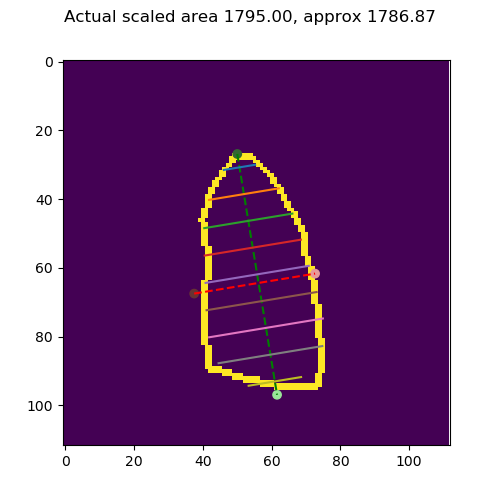

In [9]:
I = ed_label

length_I, radius_I, points_I = get2dPucks((I == 1).astype('int'), (1.0, 1.0), vis=True, debug=False)

In [10]:
length_I, radius_I, points_I.shape

(71.0028454560969,
 array([ 4.60282279, 10.27377881, 12.98911437, 14.1711838 , 15.2068915 ,
        16.22136337, 16.76408883, 15.28840218,  7.72995894]),
 (9, 1, 2, 2))

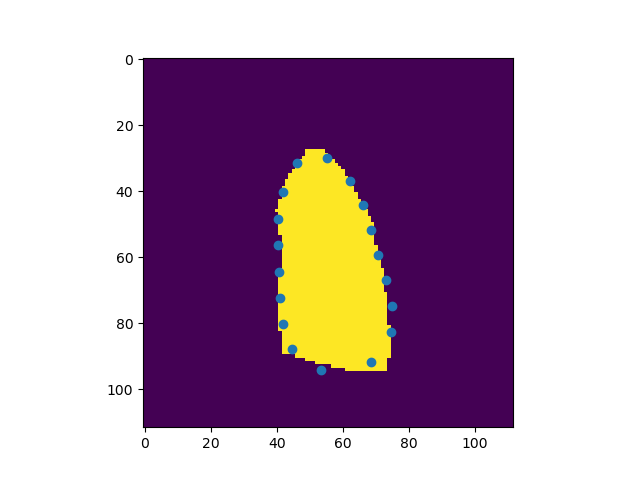

In [11]:
plt.figure()
plt.imshow(ed_label)
plt.scatter(points_I[:, 0, 1], points_I[:, 0, 0])

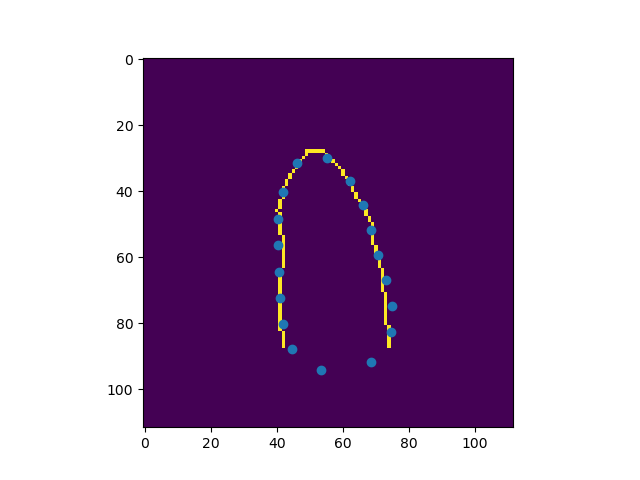

In [12]:
plt.figure()
plt.imshow(give_boundary_no_basal_plane(ed_label))
plt.scatter(points_I[:, 0, 1], points_I[:, 0, 0])

In [13]:
N = 3
indeces_for_slice_points = []
for i in range(len(points_I)-1, 0, -N):
    indeces_for_slice_points.append(i)
indeces_for_slice_points.sort()
indeces_for_slice_points

[2, 5, 8]

In [14]:
slice_points = []

for i in indeces_for_slice_points:
    slice_points.append(points_I[i, 0, ...])
    
slice_points = np.array(slice_points)

In [15]:
print(slice_points)
slice_points.shape

[[[48.41488607 44.17987968]
  [40.37906493 66.00977091]]

 [[72.29281427 67.00395657]
  [41.04838221 73.05710763]]

 [[94.25953644 91.73923948]
  [53.28452022 68.53762364]]]


(3, 2, 2)

In [16]:
x,y = slice_points[0][0][0], slice_points[0][1][0]
print(x,y)

48.41488607110273 40.37906492729051


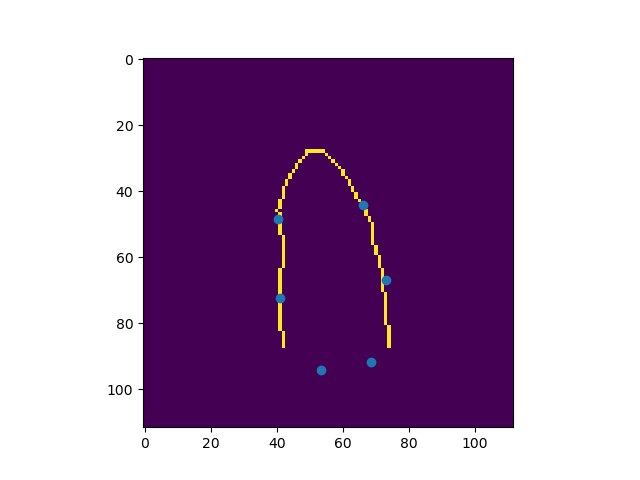

In [17]:
plt.figure()
plt.imshow(give_boundary_no_basal_plane(ed_label))
plt.scatter(slice_points[:, 1], slice_points[:, 0]) # plot in x,y --- stored in i,j

## The whole point of using the 2d pucks is to slice it NOT horizontally.
## we want to slice it slanted however much the minor axis is angled

In [18]:
# i think it would be easiest to just slice by taking the pixels in the section above the lowest of the pair of pixels for each radii line 
# instead of somehow drawing a slanted line btwn the two points

lower_points = []

for i in range(slice_points.shape[0]):
    x = slice_points[i]
    i_1, i_2 = x[0][0], x[0][1]
    if i_1 > i_2:
        x = x[:, 0]
    else:
        x = x[:, 1]
    lower_points.append(x)
lower_points = np.array(lower_points)
print(lower_points.shape)

(3, 2)


In [19]:
lower_points

array([[48.41488607, 40.37906493],
       [72.29281427, 41.04838221],
       [94.25953644, 53.28452022]])

In [20]:
lower_points = lower_points.astype('int')
lower_points

array([[48, 40],
       [72, 41],
       [94, 53]])

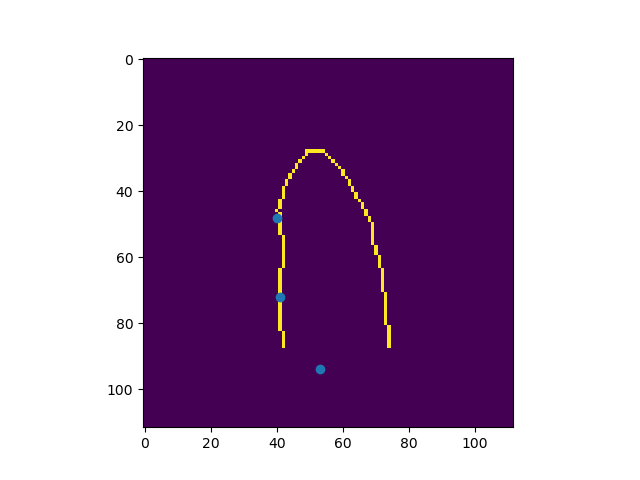

In [21]:
plt.figure()
plt.imshow(give_boundary_no_basal_plane(ed_label))
plt.scatter(lower_points[:, 1], lower_points[:, 0]) # plot in x,y --- stored in i,j

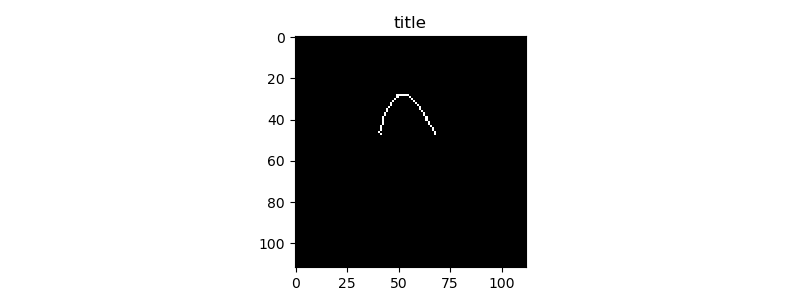

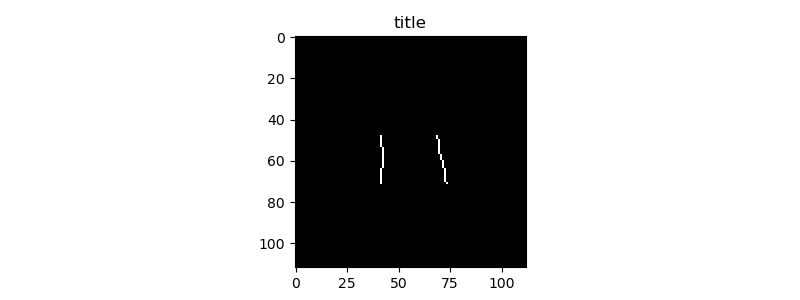

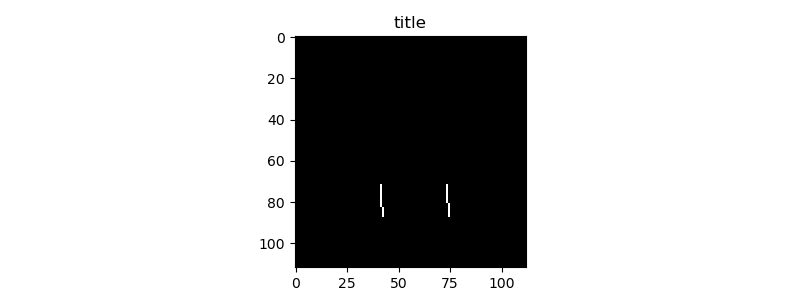

In [22]:
lower_points = np.insert(lower_points, 0, [0,0], axis=0)

I = give_boundary_no_basal_plane(I)

import copy

I_regional_splits = [0 for i in range(N)]

for i in range(N):
    I_copy = copy.deepcopy(I)
    
    start = lower_points[i][0]
    end = lower_points[i+1][0]

    I_copy[0:start, 0:I_copy.shape[1]] = 0
    I_copy[end:I_copy.shape[0], 0:I_copy.shape[1]] = 0
    
    I_regional_splits[i] = I_copy
    
    vis_single(I_copy, cmap='gray')